# **Предварительный анализ данных и построение признаков в задачах распознавания темы текста**

## Импорт библиотек

Первым делом импортируем библиотеки, которые будут использоваться в работе

In [ ]:
# Для работы с данными
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Для обработки текста 
import nltk
import re
nltk.download("stopwords") # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.parsing.preprocessing import remove_stopwords 
from nltk.stem import WordNetLemmatizer

# Для построения моделей
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier

# Для метрик
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Загрузка датасета

In [ ]:
# Загрузим датасет
data = pd.read_csv('CNN_Articels_clean.csv')

In [ ]:
# Выведем данные
data.head()

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,3,Kathryn Vasel,2022-03-18 14:37:21,business,success,https://www.cnn.com/2022/03/18/success/pandemi...,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"success, Two years later, remote work has chan...","Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...
4,4,"Paul R. La Monica, CNN Business",2022-03-19 11:41:08,business,investing,https://www.cnn.com/2022/03/19/investing/march...,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,"investing, Why March is so volatile for stocks...",Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...


**Данный датасет содержит:**

*   author – автор статьи
*   date published – дата публикации
*   category – категория статьи
*   section – раздел(секция) статьи
*   Url – ссылка на статью
*   headline – заголовок статьи
*   description – описание статьи
*   keywords – ключевые слова
*   second headline – второй заголовок статьи
*   article text - содержимое статьи



## 2. Подготовка данных к моделированию

Прежде чем начать работу с данными, их нужно подготовить: проверить на отсутствующие значения, дубликаты итд

In [ ]:
# Посмотрим количество строк и столбцов в датасете
data.shape

(37949, 11)

Выведя размеры датасета, мы видим, что он содержит 37949 строк и 11 столбцов

Проверим датасет на нулевые значения

In [ ]:
# Выведем информацию по датасету, чтобы проверить его на нулевые значения
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37949 entries, 0 to 37948
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Index            37949 non-null  int64 
 1   Author           37949 non-null  object
 2   Date published   37949 non-null  object
 3   Category         37949 non-null  object
 4   Section          37949 non-null  object
 5   Url              37949 non-null  object
 6   Headline         37949 non-null  object
 7   Description      37949 non-null  object
 8   Keywords         37949 non-null  object
 9   Second headline  37949 non-null  object
 10  Article text     37940 non-null  object
dtypes: int64(1), object(10)
memory usage: 3.2+ MB


In [ ]:
data.isnull().sum() 

Index              0
Author             0
Date published     0
Category           0
Section            0
Url                0
Headline           0
Description        0
Keywords           0
Second headline    0
Article text       9
dtype: int64

Из результата видно, что столбец Article text содержит 9 нулевых значений, которые нужно удалить

In [ ]:
data = data.dropna()

In [ ]:
data.isnull().sum()

Index              0
Author             0
Date published     0
Category           0
Section            0
Url                0
Headline           0
Description        0
Keywords           0
Second headline    0
Article text       0
dtype: int64

Нулевые значения удалились из датасета

In [ ]:
data.shape

(37940, 11)

Теперь датасет содержит 37940 строк

Далее проверим, встречаются ли в датасете дубликаты

In [ ]:
key = ['Index',	'Author',	'Date published',	'Category',	'Section',	'Url', 'Headline',	'Description',	'Keywords',	'Second headline',	'Article text']
data_dedupped = data.drop_duplicates(subset=key)

print(data.shape)
print(data_dedupped.shape)

(37940, 11)
(37940, 11)


Видно, что дубликатов нет, так как не изменилось количество записей после удаления дубликатов. Значит датасет не требует удаления дубликатов

Рассмотрим категориальные признаки. Выведем описательную статистику для них

In [ ]:
cont_features = ['Author',	'Date published', 'Category',	'Section',	'Url',	'Description',	'Keywords',	'Second headline',	'Article text'] 

In [ ]:
data[cont_features].describe()

,Author,Date published,Category,Section,Url,Description,Keywords,Second headline,Article text
count,37940,37940,37940,37940,37940,37940,37940,37940,37940
unique,11739,37939,9,55,37940,37820,37854,37872,37918
top,By,2016-02-17 14:08:53,news,europe,https://www.cnn.com/2021/07/14/world/tusimple-...,,"app-news-section, Must-watch videos of the wee...",Must-watch videos of the week,\n
freq,3285,2,18069,10627,1,22,14,14,14


Задача данной работы - распознать тему текста. Тему текста определим за столбец Category. Из показателей видно, что у него 9 уникальных категорий

Рассмотрим количественные признаки и также выведем описательную статистику

In [ ]:
# Описательная статистика количественных данных
data[['Index']].describe()

,Index
count,37940.000000
mean,25144.544412
std,11980.820600
min,0.000000
25%,16091.750000
50%,25688.500000
75%,35237.250000
max,44997.000000


К количественным признакам у нас относится только столбец Index, который не будет иметь сильного влияния при обучении и моделировании данных, поэтому его можно удалить

In [ ]:
data = data.drop(['Index'], axis = 1)

Также можно удалить столбуц Url, поскольку он не содержит никакой важной информации для обработки и обучения модели

In [ ]:
data = data.drop(['Url'], axis = 1)
data.head()

,Author,Date published,Category,Section,Headline,Description,Keywords,Second headline,Article text
0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,Kathryn Vasel,2022-03-18 14:37:21,business,success,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"success, Two years later, remote work has chan...","Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...
4,"Paul R. La Monica, CNN Business",2022-03-19 11:41:08,business,investing,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,"investing, Why March is so volatile for stocks...",Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...


## Анализ данных

Проведем предварительный анализ датасета

### Категории и секции

Проанализируем данные: посмотрим, какие секции и категории встречаются чаще всего в датасете 





In [ ]:
# Выведем еще раз датасет для наглядности
data.head()

,Author,Date published,Category,Section,Headline,Description,Keywords,Second headline,Article text
0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,Kathryn Vasel,2022-03-18 14:37:21,business,success,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"success, Two years later, remote work has chan...","Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...
4,"Paul R. La Monica, CNN Business",2022-03-19 11:41:08,business,investing,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,"investing, Why March is so volatile for stocks...",Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...


Сгруппириуем датасет по категориям и посмотрим, сколько раз каждая категория встречается в датасете

In [ ]:
category = data.groupby('Category').count()
category = category.drop(['Author', 'Date published', 'Headline',	'Description',	'Keywords',	'Second headline',	'Article text'], axis = 1) 
category = category.rename(columns = {'Section': 'Count category'})
category = category.reset_index()
category.sort_values('Count category', ascending= False)

,Category,Count category
3,news,18069
5,sport,15541
4,politics,2461
0,business,854
2,health,557
1,entertainment,413
7,travel,39
8,vr,5
6,style,1


In [ ]:
len(category)

9

<Axes: xlabel='Category', ylabel='Count'>

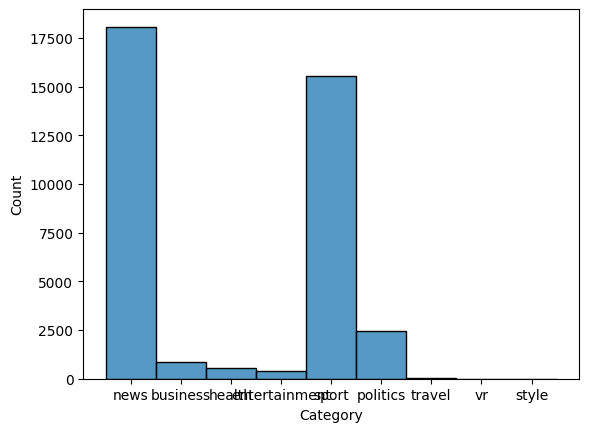

In [ ]:
sns.histplot(data['Category'])

Выведя длину, мы видим, что встречается всего **9** различных категорий: **news, sport, politics, business, health, enterteinment, travel, vr, style**. \
По отсортированному в таблицу количеству видно, что больше всего авторы использовали news темы в своих статьях. \
Такие же показатели показывает гистограмма


Сгруппируем датасет по секциям статей

In [ ]:
section = data.groupby('Section').count()
section = section.drop(['Author', 'Date published', 'Headline',	'Description',	'Keywords',	'Second headline',	'Article text'], axis = 1) 
section = section.reset_index()
section = section.rename(columns = {'Category': 'Count section'})
section.sort_values('Count section', ascending=False)

,Section,Count section
19,europe,10627
44,sport,5638
22,football,4911
40,politics,2461
50,us,2119
47,tennis,2100
49,uk,1856
23,golf,1498
35,motorsport,1386
38,opinions,850


In [ ]:
section.shape

(55, 2)

<Axes: xlabel='Section', ylabel='Count'>

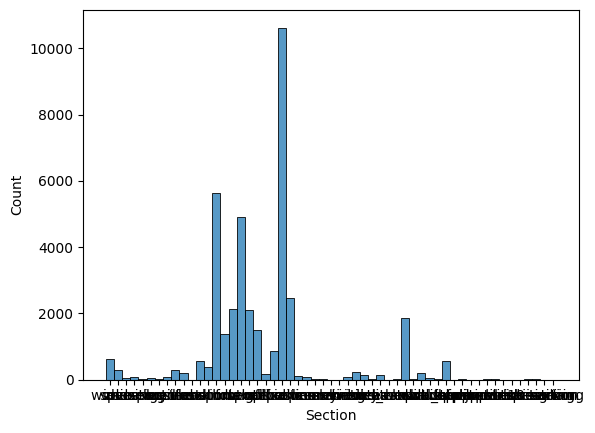

In [ ]:
sns.histplot(data['Section'])

Самая часто встречающаяся секция - europe 

Создадим таблицу, в которой выведем секции, их количество и категории текста

In [ ]:
table = data[['Section', 'Category']].drop_duplicates().merge(section, how = 'left', on = 'Section')
table

,Section,Category,Count section
0,world,news,614
1,asia,news,301
2,success,business,41
3,investing,business,82
4,energy,business,21
5,perspectives,business,41
6,business-food,business,4
7,media,business,85
8,business,business,284
9,tech,business,205


Так мы видим, что у нас в датасете 55 уникальных секций статей. Для каждой из них мы видим соответствующую категорию статьи и сколько раз каждая секция встречается в датасете

In [ ]:
table.sort_values('Count section', ascending=False)

,Section,Category,Count section
21,europe,news,10627
13,sport,sport,5638
16,football,sport,4911
22,politics,politics,2461
15,us,news,2119
17,tennis,sport,2100
36,uk,news,1856
18,golf,sport,1498
14,motorsport,sport,1386
20,opinions,news,850


По полученным данным видно, что sport, europe, football, politics, us, tennis, uk, golf, motosport встречаются более 1000 раз, поэтому их из секций можно вынести в отдельные категории 

In [ ]:
data['Category'] = np.where((data['Section'] == 'europe'), data['Section'], data['Category'])
data['Category'] = np.where((data['Section'] == 'sport'), data['Section'], data['Category'])
data['Category'] = np.where((data['Section'] == 'football'), data['Section'], data['Category'])
data['Category'] = np.where((data['Section'] == 'politics'), data['Section'], data['Category'])
data['Category'] = np.where((data['Section'] == 'us'), data['Section'], data['Category'])
data['Category'] = np.where((data['Section'] == 'tennis'), data['Section'], data['Category'])
data['Category'] = np.where((data['Section'] == 'uk'), data['Section'], data['Category'])
data['Category'] = np.where((data['Section'] == 'golf'), data['Section'], data['Category'])
data['Category'] = np.where((data['Section'] == 'motosport'), data['Section'], data['Category'])

In [ ]:
data.head()

,Author,Date published,Category,Section,Headline,Description,Keywords,Second headline,Article text
0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,Kathryn Vasel,2022-03-18 14:37:21,business,success,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"success, Two years later, remote work has chan...","Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...
4,"Paul R. La Monica, CNN Business",2022-03-19 11:41:08,business,investing,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,"investing, Why March is so volatile for stocks...",Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...


In [ ]:
category = data.groupby('Category').count()
category

,Author,Date published,Section,Headline,Description,Keywords,Second headline,Article text
Category,,,,,,,,
business,854,854,854,854,854,854,854,854
entertainment,413,413,413,413,413,413,413,413
europe,10627,10627,10627,10627,10627,10627,10627,10627
football,4911,4911,4911,4911,4911,4911,4911,4911
golf,1498,1498,1498,1498,1498,1498,1498,1498
health,557,557,557,557,557,557,557,557
news,3467,3467,3467,3467,3467,3467,3467,3467
politics,2461,2461,2461,2461,2461,2461,2461,2461
sport,7032,7032,7032,7032,7032,7032,7032,7032


### Автор и категории

Рассмотрим зависимость автора от категорий статьи

In [ ]:
author = data['Author']
set(author)

{'By Lauren Lee-Johnson',
 'Steven Jiang and Jessie Yeung, CNN',
 'By Eliott C. McLaughlin and Marlena Baldacci, CNN',
 'Elizabeth Roberts and Eliott C. McLaughlin, CNN',
 'Rob Picheta and Antonella Francini, CNN',
 'Mohammed Tawfeeq and Hande Atay Alam, CNN and Reuters',
 'Don Lemon and Ben Church, CNN',
 'Jarrett Bellini, CNN',
 'Arwa Damon, AnneClaire Stapleton and Alex Platt, CNN',
 'Laura He, CNN Business',
 'Natasha Bertrand, Maegan Vazquez, Jasmine Wright and Donald Judd, CNN',
 'Exclusive by Matthew Chance and Zahra Ullah, CNN',
 'Greg Botelho and Dominique Heckels, CNN',
 'Helena Cavendish de Moura, Special to CNN',
 'Story by Thomas Page, video by Jon Jensen, CNN',
 'Story By John Blake, CNN\nVideo by Tawanda Scott Sambou, CNN',
 'Nima Elbagir, Barbara Arvanitidis and Eoin McSweeney, CNN',
 'Ben Brumfield, CNN',
 'Holly Yan and Martin Savidge, CNN',
 'Tim Lister, Maria Ilyushina and Darya Tarasova, CNN',
 'Kara Fox and Stephanie Busari, CNN\nVideo by Edward Kiernan, CNN',
 'B

Мы вывели всех возможных авторов

In [ ]:
author = data.groupby('Author').count()
author = author.drop(['Date published', 'Category', 'Headline',	'Description',	'Keywords',	'Second headline',	'Article text'], axis = 1)
author = author.rename(columns = {'Section': 'Count author'})
author = author.reset_index()
author.sort_values('Count author', ascending=False)

,Author,Count author
1679,By,3285
7907,"Matias Grez, CNN",686
1387,"Ben Morse, CNN",584
2954,By the CNN Wire Staff,575
5011,"George Ramsay, CNN",562
...,...,...
4452,"Esra Gurkan, for CNN",1
4453,"Etant Dupain, AnneClaire Stapleton and Mohamme...",1
4455,"Ethan Cohen and Gregory Krieg, CNN",1
4456,"Ethan Cohen, CNN",1


Из таблицы видно, что всего в датасете 11739 уникальных авторов. Некоторые встречаются не 1 раз. Значит, авторы относятся к каким-то категориям и поэтому данный столбец удалять не нужно


### Отбор данных

Благодаря приведенному выше анализу, у нас остались нужные для обработки столбцы. Объединим их в один текст для дальнейшей обработки

In [ ]:
data['text'] = data['Author']+ '. ' + data['Section']+ '. ' + data['Headline']+ '. '+ data['Description'] + '. '+ data['Second headline'] + '. ' + data['Article text']
data = data.drop(['Author', 'Date published', 'Headline', 'Section', 'Description', 'Article text', 'Keywords', 'Second headline'], axis = 1)
data

,Category,text
0,news,"Jacopo Prisco, CNN. world. There's a shortage ..."
1,news,"Stephanie Bailey, CNN. world. Bioservo's robot..."
2,news,"Words by Stephanie Bailey, video by Zahra Jams..."
3,business,"Kathryn Vasel . success. Two years later, remo..."
4,business,"Paul R. La Monica, CNN Business. investing. Wh..."
...,...,...
37944,sport,"Ben Church and Aleks Klosok, CNN. sport. Russi..."
37945,europe,"Tamara Qiblawi, CNN . europe. On NATO's doorst..."
37946,sport,"Wayne Sterling and Steve Almasy, CNN. sport. M..."
37947,europe,CNN Editorial Research. europe. Mikhail Gorbac...


## Обработка данных

Для качественной работы с данными нам нужно обработать текст:
- Удалить стоп-слова
- Удалить знаки препинания
- Сравнять регистр слов 
- Выделить основы слова
- Преобразовать текст в цифры для обучения


### Удаление неалфавитных символов

**1. Удаление неалфавитных символов** \
C помощью регулярных выражений удалим неалфавитные символы (заменим их на строки в нашем тексте)

In [ ]:
data['text']

0        Jacopo Prisco, CNN. world. There's a shortage ...
1        Stephanie Bailey, CNN. world. Bioservo's robot...
2        Words by Stephanie Bailey, video by Zahra Jams...
3        Kathryn Vasel . success. Two years later, remo...
4        Paul R. La Monica, CNN Business. investing. Wh...
                               ...                        
37944    Ben Church and Aleks Klosok, CNN. sport. Russi...
37945    Tamara Qiblawi, CNN . europe. On NATO's doorst...
37946    Wayne Sterling and Steve Almasy, CNN. sport. M...
37947    CNN Editorial Research. europe. Mikhail Gorbac...
37948    CNN Editorial Research. europe. Duchess Camill...
Name: text, Length: 37940, dtype: object

In [ ]:
text = data['text']
text = text.apply(lambda x: re.sub('[^a-zA-Z]', ' ', str(x)))
text

0        Jacopo Prisco  CNN  world  There s a shortage ...
1        Stephanie Bailey  CNN  world  Bioservo s robot...
2        Words by Stephanie Bailey  video by Zahra Jams...
3        Kathryn Vasel   success  Two years later  remo...
4        Paul R  La Monica  CNN Business  investing  Wh...
                               ...                        
37944    Ben Church and Aleks Klosok  CNN  sport  Russi...
37945    Tamara Qiblawi  CNN   europe  On NATO s doorst...
37946    Wayne Sterling and Steve Almasy  CNN  sport  M...
37947    CNN Editorial Research  europe  Mikhail Gorbac...
37948    CNN Editorial Research  europe  Duchess Camill...
Name: text, Length: 37940, dtype: object

Видно, что все знаки препинания удалились и остались только алфавитные символы

In [ ]:
data['text'] = text

### Токенизация

**2. Токенизация** \
Разделим текст на слова с помощью токенизации и метода word_tokenize из библиотеки nltk.tokenize

In [ ]:
data['text'] = pd.DataFrame(data['text'].apply(lambda x: word_tokenize(x))); data.head()

,Category,text
0,news,"[Jacopo, Prisco, CNN, world, There, s, a, shor..."
1,news,"[Stephanie, Bailey, CNN, world, Bioservo, s, r..."
2,news,"[Words, by, Stephanie, Bailey, video, by, Zahr..."
3,business,"[Kathryn, Vasel, success, Two, years, later, r..."
4,business,"[Paul, R, La, Monica, CNN, Business, investing..."


### Удаление стоп-слов

**3. Удаление стоп-слов** \
Удалим стоп-слова из текста 

In [ ]:
data['text'] = pd.DataFrame(data)['text'].apply(lambda x: " ".join([remove_stopwords(i) for i in x]))

In [ ]:
data['text'].head()

0    Jacopo Prisco CNN world There s  shortage  tru...
1    Stephanie Bailey CNN world Bioservo s robotic ...
2    Words  Stephanie Bailey video  Zahra Jamshed a...
3    Kathryn Vasel success Two years later remote w...
4    Paul R La Monica CNN Business investing Why Ma...
Name: text, dtype: object

### Лемматизация

**4. Лемматизация** \
К полученному набору слов применим лемматизацию, чтобы выделить основы слов

In [ ]:
lemmatizer = WordNetLemmatizer() # объект класса
data['text'] = pd.DataFrame(data['text'].apply(lambda x: lemmatizer.lemmatize(x)))
data['text'].head()

0    Jacopo Prisco CNN world There s  shortage  tru...
1    Stephanie Bailey CNN world Bioservo s robotic ...
2    Words  Stephanie Bailey video  Zahra Jamshed a...
3    Kathryn Vasel success Two years later remote w...
4    Paul R La Monica CNN Business investing Why Ma...
Name: text, dtype: object

In [ ]:
data['text'][0]

'Jacopo Prisco CNN world There s  shortage  truckers  TuSimple thinks    solution  driver needed CNN The e commerce boom  exacerbated  global truck driver shortage   autonomous trucks help fix  problem There s  shortage  truckers  TuSimple thinks    solution  driver needed CNN Right   s  shortage  truck drivers   US  worldwide exacerbated   e commerce boom brought    pandemic One solution   problem  autonomous trucks   companies    race      launch  Among   San Diego based TuSimple Founded  TuSimple  completed  million miles  road tests   prototype trucks   US China  Europe Although   simply commercially available trucks retrofitted   technology TuSimple  deals  place     world s largest truck manufacturers Navistar   US  Traton Volkswagen s trucking business  Europe  design  build fully autonomous models   hopes  launch  Photos The Yara Birkeland    builders   world s  zero emission autonomous cargo ship The ship  scheduled     journey   Norwegian towns   end   year Click     forms  t

## Построение моделей

### Разделение на тестовые и тренировочные данные

Для начала разделим данные на тестовые и тренировочные, чтобы затем сравнивать получаенные после моделирования результаты. Обучать будем тестовые данные

Выделим целевую переменную y и признаки X. \
За y возьмем столбец с категориями - Category, за X оставшиеся столбцы: section и text, которая содержит в себе и заголовки и описание и полный текст.

In [ ]:
y = data.Category
X = data.drop('Category', axis = 1)

In [ ]:
y.head()

0        news
1        news
2        news
3    business
4    business
Name: Category, dtype: object

In [ ]:
X.head()

,text
0,Jacopo Prisco CNN world There s shortage tru...
1,Stephanie Bailey CNN world Bioservo s robotic ...
2,Words Stephanie Bailey video Zahra Jamshed a...
3,Kathryn Vasel success Two years later remote w...
4,Paul R La Monica CNN Business investing Why Ma...


Разделим данные с помощью функции из библиотеки sklearn - train_test_split. ДЛя тестовых возьмем 30% 

In [ ]:
X = X.text.values
X

array(['Jacopo Prisco CNN world There s  shortage  truckers  TuSimple thinks    solution  driver needed CNN The e commerce boom  exacerbated  global truck driver shortage   autonomous trucks help fix  problem There s  shortage  truckers  TuSimple thinks    solution  driver needed CNN Right   s  shortage  truck drivers   US  worldwide exacerbated   e commerce boom brought    pandemic One solution   problem  autonomous trucks   companies    race      launch  Among   San Diego based TuSimple Founded  TuSimple  completed  million miles  road tests   prototype trucks   US China  Europe Although   simply commercially available trucks retrofitted   technology TuSimple  deals  place     world s largest truck manufacturers Navistar   US  Traton Volkswagen s trucking business  Europe  design  build fully autonomous models   hopes  launch  Photos The Yara Birkeland    builders   world s  zero emission autonomous cargo ship The ship  scheduled     journey   Norwegian towns   end   year Click     f

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
X_test.shape, X_train.shape 

((11382,), (26558,))

Выведя размер тестовых и тренировояных признаков видно, что данные разделились в правильном соотношении

Построим для наглядности гистограмму распределения тестовых и обучаемых данных каждой категории

In [ ]:
y_train_val = y_train.value_counts(); y_train_val

europe           7403
sport            4934
football         3434
news             2443
politics         1718
tennis           1485
us               1479
uk               1284
golf             1057
business          593
health            404
entertainment     298
travel             23
vr                  2
style               1
Name: Category, dtype: int64

In [ ]:
y_test_val = y_test.value_counts(); y_test_val

europe           3224
sport            2098
football         1477
news             1024
politics          743
us                640
tennis            615
uk                572
golf              441
business          261
health            153
entertainment     115
travel             16
vr                  3
Name: Category, dtype: int64

Посмотрим распределение тестовых и тренировочных данных на диаграмме

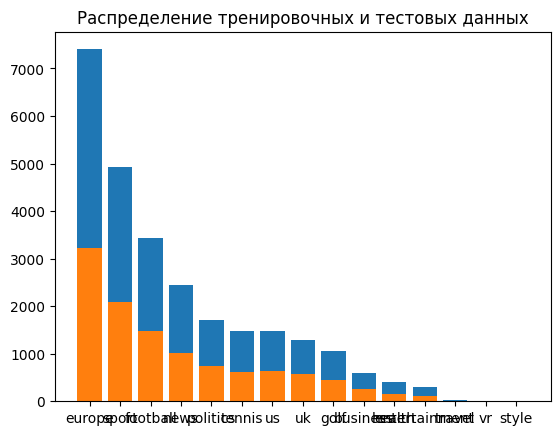

In [ ]:
fig, ax = plt.subplots()
ax.bar(y_train_val.index, y_train_val, linewidth=0.7)
ax.bar(y_test_val.index, y_test_val, linewidth=0.7)
ax.set_title('Распределение тренировочных и тестовых данных')
plt.show()

Чтобы обучать модель, необходимо текстовые данные преобразовать в числовые (векторизировать). Будем использовать CountVectorizer

CountVectorizer преобразует текст в цифры, показывая количество раз встречабщегося слова в тексте

Создадим таблицу, в которую будем добавлять полученные метрик для сравнения

In [ ]:
table_metrics = pd.DataFrame(columns = ['Logistic'],
                              index = ['accuracy_score', 'recall', 'precision'])

In [ ]:
table_metrics

,Logistic
accuracy_score,NaN
recall,NaN
precision,NaN


### LogisticRegression - логистическая регрессия

Вооспользуемся моделбю Pipeline, которая позволяет одновременно запустить обучение логистической регрессии и векторизацию

In [ ]:
%%time
logistic_model = Pipeline([('cv', CountVectorizer()), ('logistic', LogisticRegression())])
logistic_model.fit(X_train, y_train)
y_pred_cv = logistic_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 3min 49s, sys: 47.8 s, total: 4min 36s
Wall time: 3min 50s


In [ ]:
print(classification_report(y_test, y_pred_cv))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

     business       0.88      0.82      0.85       261
entertainment       0.85      0.81      0.83       115
       europe       0.93      0.95      0.94      3224
     football       0.94      0.94      0.94      1477
         golf       0.96      0.94      0.95       441
       health       0.72      0.64      0.68       153
         news       0.81      0.79      0.80      1024
     politics       0.96      0.90      0.93       743
        sport       0.92      0.92      0.92      2098
       tennis       0.93      0.95      0.94       615
       travel       0.00      0.00      0.00        16
           uk       0.85      0.85      0.85       572
           us       0.77      0.82      0.80       640
           vr       0.00      0.00      0.00         3

     accuracy                           0.90     11382
    macro avg       0.75      0.74      0.75     11382
 weighted avg       0.90      0.90      0.90     11382



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


По выведенным метрикам видно, что получились очень хорошие показатели и модель удачно обучилась с высокой точностью

Добавим получившиеся показатели метрик в общую таблицу

In [ ]:
table_metrics['Logistic']['accuracy_score'] = round(accuracy_score(y_test, y_pred_cv)*100, 2) # точность подмножества
table_metrics['Logistic']['recall'] = round(recall_score(y_test, y_pred_cv, average = 'macro')*100, 2) # точность подмножества
table_metrics['Logistic']['precision'] = round(precision_score(y_test, y_pred_cv, average = 'macro')*100, 2) # точность подмножества


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
table_metrics

,Logistic
accuracy_score,90.45
recall,73.9
precision,75.27


### KNeighborsClassifier - метод ближайших соседей

**KNN с CountVectorizer**

In [ ]:
%%time
knn_model = Pipeline([('cv', CountVectorizer()), ('knn', KNeighborsClassifier())])
knn_model.fit(X_train, y_train)
y_pred_cv = knn_model.predict(X_test)

CPU times: user 1min 14s, sys: 7.04 s, total: 1min 21s
Wall time: 1min 22s


In [ ]:
print(classification_report(y_test, y_pred_cv))

               precision    recall  f1-score   support

     business       0.66      0.28      0.40       261
entertainment       0.29      0.12      0.17       115
       europe       0.72      0.71      0.72      3224
     football       0.91      0.77      0.83      1477
         golf       0.90      0.69      0.78       441
       health       0.64      0.23      0.34       153
         news       0.63      0.26      0.37      1024
     politics       0.79      0.54      0.64       743
        sport       0.43      0.90      0.59      2098
       tennis       0.91      0.79      0.85       615
       travel       0.00      0.00      0.00        16
           uk       0.74      0.45      0.56       572
           us       0.76      0.24      0.37       640
           vr       0.00      0.00      0.00         3

     accuracy                           0.64     11382
    macro avg       0.60      0.43      0.47     11382
 weighted avg       0.70      0.64      0.63     11382



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Добавим получившиеся показатели метрик в общую таблицу

In [ ]:
table_metrics['KNN'] = [round(accuracy_score(y_test, y_pred_cv)*100, 2), round(recall_score(y_test, y_pred_cv, average = 'macro')*100, 2), round(precision_score(y_test, y_pred_cv, average = 'macro')*100, 2)]
table_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Logistic,KNN
accuracy_score,90.45,64.35
recall,73.9,42.85
precision,75.27,59.84


В данной модели метрики получились хуже, чем в логистической регрессии

### Multinomial Naive Bayes - наивный баессовский классификатор

**MultinomialNB с CountVectorizer**

In [ ]:
%%time
nb_model = Pipeline([('cv', CountVectorizer()), ('nb', MultinomialNB())])
nb_model.fit(X_train, y_train)
y_pred_cv = nb_model.predict(X_test)

CPU times: user 25.6 s, sys: 167 ms, total: 25.8 s
Wall time: 26.7 s


In [ ]:
print(classification_report(y_test, y_pred_cv))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

     business       0.83      0.64      0.72       261
entertainment       0.84      0.32      0.47       115
       europe       0.90      0.84      0.87      3224
     football       0.94      0.95      0.95      1477
         golf       0.93      0.93      0.93       441
       health       0.71      0.53      0.61       153
         news       0.59      0.70      0.64      1024
     politics       0.80      0.86      0.83       743
        sport       0.90      0.89      0.89      2098
       tennis       0.91      0.96      0.93       615
       travel       0.00      0.00      0.00        16
           uk       0.62      0.67      0.65       572
           us       0.66      0.78      0.72       640
           vr       0.00      0.00      0.00         3

     accuracy                           0.83     11382
    macro avg       0.69      0.65      0.66     11382
 weighted avg       0.84      0.83      0.83     11382



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Добавим получившиеся показатели метрик в общую таблицу

In [ ]:
table_metrics['MultinomialNB'] = [round(accuracy_score(y_test, y_pred_cv)*100, 2), round(recall_score(y_test, y_pred_cv, average = 'macro')*100, 2), round(precision_score(y_test, y_pred_cv, average = 'macro')*100, 2)]
table_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Logistic,KNN,MultinomialNB
accuracy_score,90.45,64.35,83.27
recall,73.9,42.85,64.72
precision,75.27,59.84,68.79


### ComplementNB - дополняющий баессовский классификатор

**ComplementNB с CountVectorizer**

In [ ]:
%%time
сnb_model = Pipeline([('cv', CountVectorizer()), ('сnb', ComplementNB())])
сnb_model.fit(X_train, y_train)
y_pred_cv = сnb_model.predict(X_test)

CPU times: user 29.5 s, sys: 165 ms, total: 29.7 s
Wall time: 31.3 s


In [ ]:
print(classification_report(y_test, y_pred_cv))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

     business       0.85      0.58      0.69       261
entertainment       0.72      0.54      0.62       115
       europe       0.81      0.93      0.87      3224
     football       0.93      0.97      0.95      1477
         golf       0.92      0.98      0.95       441
       health       0.68      0.49      0.57       153
         news       0.68      0.58      0.63      1024
     politics       0.76      0.86      0.81       743
        sport       0.93      0.90      0.92      2098
       tennis       0.89      1.00      0.94       615
       travel       0.00      0.00      0.00        16
           uk       0.83      0.41      0.55       572
           us       0.78      0.68      0.72       640
           vr       0.00      0.00      0.00         3

     accuracy                           0.84     11382
    macro avg       0.70      0.64      0.66     11382
 weighted avg       0.84      0.84      0.83     11382



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Добавим получившиеся показатели метрик в общую таблицу

In [ ]:
table_metrics['ComplementNB'] = [round(accuracy_score(y_test, y_pred_cv)*100, 2), round(recall_score(y_test, y_pred_cv, average = 'macro')*100, 2), round(precision_score(y_test, y_pred_cv, average = 'macro')*100, 2)]
table_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Logistic,KNN,MultinomialNB,ComplementNB
accuracy_score,90.45,64.35,83.27,84.19
recall,73.9,42.85,64.72,63.82
precision,75.27,59.84,68.79,69.91


Метрики получились выше, чем у MNB модели

### DecisionTreeClassifier - классификатор деревья решений

**DecisionTreeClassifier с CountVectorizer**

In [ ]:
%%time
tree_model = Pipeline([('cv', CountVectorizer()), ('tree', DecisionTreeClassifier())])
tree_model.fit(X_train, y_train)
y_pred_cv = tree_model.predict(X_test)

CPU times: user 1min 59s, sys: 634 ms, total: 2min
Wall time: 2min 6s


In [ ]:
print(classification_report(y_test, y_pred_cv))

               precision    recall  f1-score   support

     business       0.77      0.76      0.77       261
entertainment       0.82      0.75      0.78       115
       europe       0.95      0.96      0.96      3224
     football       0.91      0.94      0.92      1477
         golf       0.92      0.92      0.92       441
       health       0.49      0.52      0.51       153
         news       0.78      0.72      0.75      1024
     politics       1.00      1.00      1.00       743
        sport       0.92      0.91      0.91      2098
       tennis       0.88      0.92      0.90       615
       travel       0.00      0.00      0.00        16
           uk       0.84      0.86      0.85       572
           us       0.70      0.70      0.70       640
           vr       1.00      0.67      0.80         3

     accuracy                           0.89     11382
    macro avg       0.78      0.76      0.77     11382
 weighted avg       0.89      0.89      0.89     11382



Добавим получившиеся показатели метрик в общую таблицу

In [ ]:
table_metrics['DecisionTreeClassifier'] = [round(accuracy_score(y_test, y_pred_cv)*100, 2), round(recall_score(y_test, y_pred_cv, average = 'macro')*100, 2), round(precision_score(y_test, y_pred_cv, average = 'macro')*100, 2)]
table_metrics

,Logistic,KNN,MultinomialNB,ComplementNB,DecisionTreeClassifier
accuracy_score,90.45,64.35,83.27,84.19,89.17
recall,73.9,42.85,64.72,63.82,75.89
precision,75.27,59.84,68.79,69.91,78.45


### PassiveAggressiveClassifier - пассивно-агрессивный классификатор

**PassiveAggressiveClassifier с CountVectorizer**

In [ ]:
%%time
pass_agr_model = Pipeline([('cv', CountVectorizer()), ('pass_agr', PassiveAggressiveClassifier())])
pass_agr_model.fit(X_train, y_train)
y_pred_cv = pass_agr_model.predict(X_test)

CPU times: user 34.7 s, sys: 1.87 s, total: 36.6 s
Wall time: 35.4 s


In [ ]:
print(classification_report(y_test, y_pred_cv))

               precision    recall  f1-score   support

     business       0.88      0.82      0.85       261
entertainment       0.79      0.82      0.80       115
       europe       0.94      0.95      0.94      3224
     football       0.94      0.95      0.95      1477
         golf       0.95      0.96      0.95       441
       health       0.67      0.63      0.65       153
         news       0.83      0.80      0.81      1024
     politics       0.96      0.94      0.95       743
        sport       0.93      0.92      0.93      2098
       tennis       0.92      0.95      0.94       615
       travel       0.00      0.00      0.00        16
           uk       0.83      0.85      0.84       572
           us       0.81      0.80      0.81       640
           vr       0.00      0.00      0.00         3

     accuracy                           0.91     11382
    macro avg       0.75      0.74      0.74     11382
 weighted avg       0.91      0.91      0.91     11382



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Добавим получившиеся показатели метрик в общую таблицу

In [ ]:
table_metrics['PassiveAggressiveClassifier'] = [round(accuracy_score(y_test, y_pred_cv)*100, 2), round(recall_score(y_test, y_pred_cv, average = 'macro')*100, 2), round(precision_score(y_test, y_pred_cv, average = 'macro')*100, 2)]
table_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Logistic,KNN,MultinomialNB,ComplementNB,DecisionTreeClassifier,PassiveAggressiveClassifier
accuracy_score,90.45,64.35,83.27,84.19,89.17,90.94
recall,73.9,42.85,64.72,63.82,75.89,74.33
precision,75.27,59.84,68.79,69.91,78.45,74.67


### MLPClassifier - многослойный перцептрон

**MLPClassifier с CountVectorizer**

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
%%time
mlp_model = Pipeline([('cv', CountVectorizer()), ('mlp', MLPClassifier())])
mlp_model.fit(X_train, y_train)
y_pred_cv = mlp_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


CPU times: user 3min 11s, sys: 3min 3s, total: 6min 15s
Wall time: 5min 59s


In [ ]:
print(classification_report(y_test, y_pred_cv))

               precision    recall  f1-score   support

     business       0.89      0.77      0.83       261
entertainment       0.81      0.85      0.83       115
       europe       0.94      0.93      0.94      3224
     football       0.94      0.97      0.95      1477
         golf       0.95      0.98      0.96       441
       health       0.77      0.66      0.71       153
         news       0.81      0.81      0.81      1024
     politics       0.94      0.91      0.92       743
        sport       0.95      0.91      0.93      2098
       tennis       0.93      0.97      0.95       615
       travel       0.00      0.00      0.00        16
           uk       0.79      0.87      0.83       572
           us       0.76      0.84      0.80       640
           vr       0.00      0.00      0.00         3

     accuracy                           0.91     11382
    macro avg       0.75      0.75      0.75     11382
 weighted avg       0.91      0.91      0.91     11382



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Добавим получившиеся показатели метрик в общую таблицу

In [ ]:
table_metrics['MLPClassifier'] = [round(accuracy_score(y_test, y_pred_cv)*100, 2), round(recall_score(y_test, y_pred_cv, average = 'macro')*100, 2), round(precision_score(y_test, y_pred_cv, average = 'macro')*100, 2)]
table_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Logistic,KNN,MultinomialNB,ComplementNB,DecisionTreeClassifier,PassiveAggressiveClassifier,MLPClassifier
accuracy_score,90.45,64.35,83.27,84.19,89.17,90.94,90.63
recall,73.9,42.85,64.72,63.82,75.89,74.33,74.76
precision,75.27,59.84,68.79,69.91,78.45,74.67,74.87


## Сравнение моделей

In [ ]:
table_metrics

,Logistic,KNN,MultinomialNB,ComplementNB,DecisionTreeClassifier,PassiveAggressiveClassifier,MLPClassifier
accuracy_score,90.45,64.35,83.27,84.19,89.17,90.94,90.63
recall,73.9,42.85,64.72,63.82,75.89,74.33,74.76
precision,75.27,59.84,68.79,69.91,78.45,74.67,74.87


In [ ]:
# table_metrics = table_metrics.reset_index()
table_metrics = table_metrics.drop('index', axis = 1)
table_metrics 

,Logistic,KNN,MultinomialNB,ComplementNB,DecisionTreeClassifier,PassiveAggressiveClassifier,MLPClassifier
0,90.45,64.35,83.27,84.19,89.17,90.94,90.63
1,73.9,42.85,64.72,63.82,75.89,74.33,74.76
2,75.27,59.84,68.79,69.91,78.45,74.67,74.87


Построим тепловую матрицу, которая наглядно выведет полученные метрики

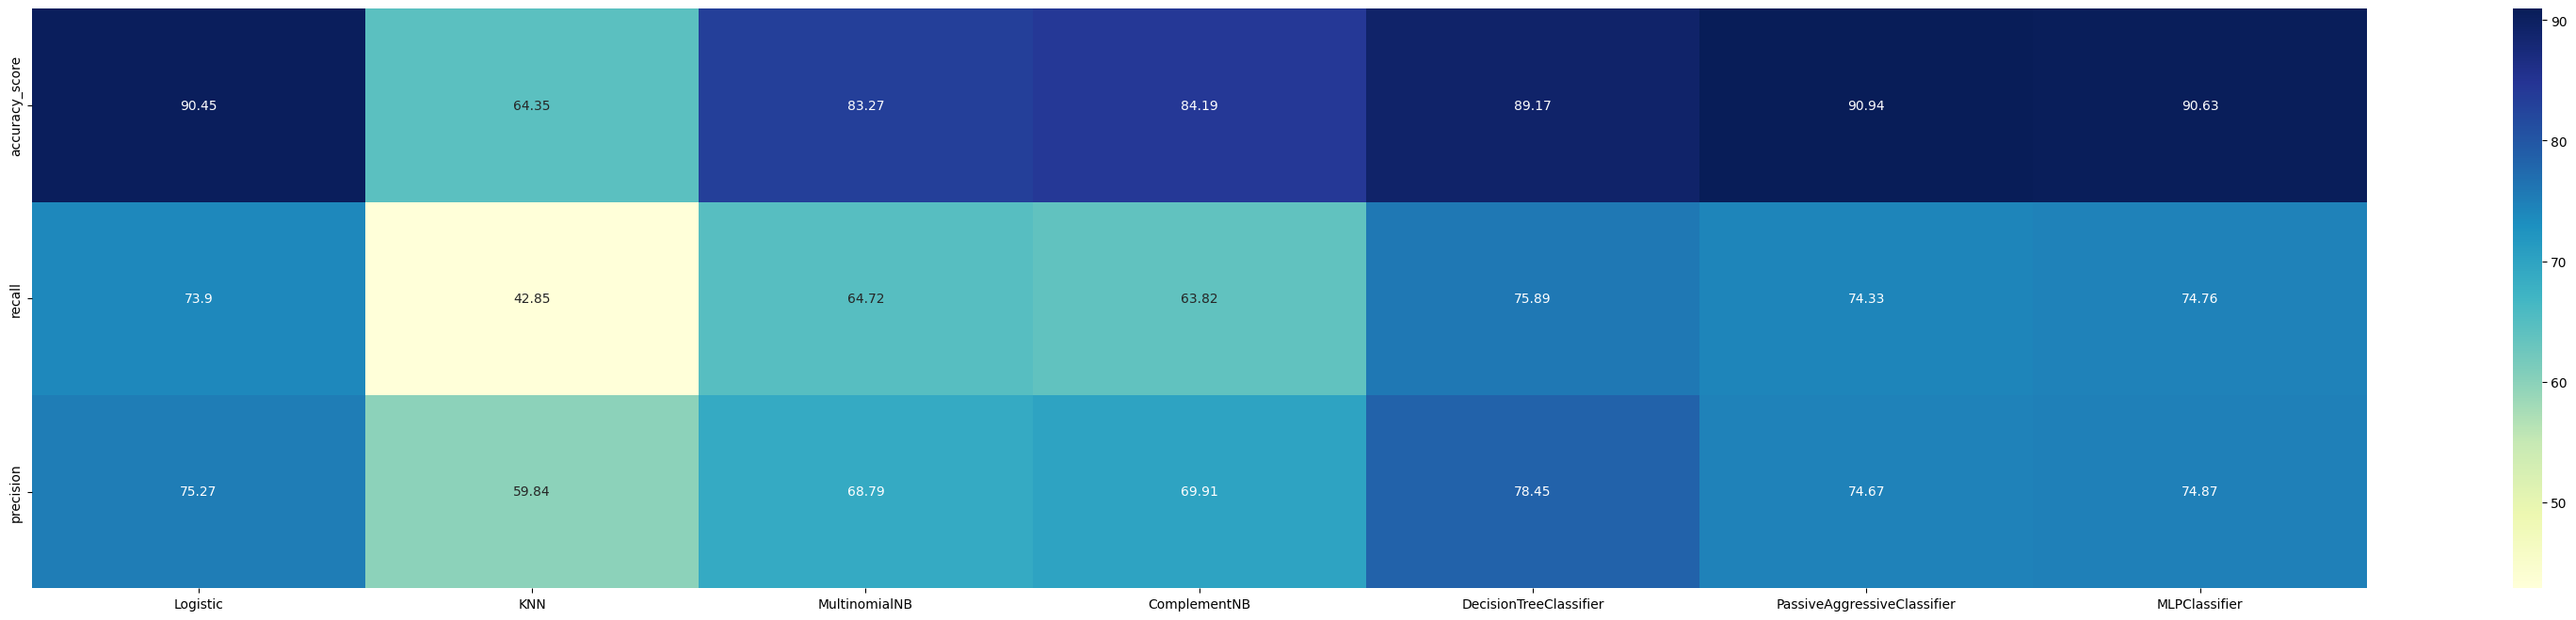

In [ ]:
fig, ax = plt.subplots(figsize = (40, 8))
sns.heatmap(table_metrics.fillna(0),  yticklabels = ['accuracy_score', 'recall', 'precision'], annot = True, fmt = '.6g', cmap = 'YlGnBu')
plt.show()

Почти все модели показали хорошие показатели. Наилучшие у классификатора дерева решений - DecisionTreeClassifier.

## Заключение

В данной работе был использован датасет,содержащий 11 признаков и 37949 строк. 
В ходе проведения исследования некоторые ненужные признаки удалялись. Над текстом была проведена обработка - удаление стоп-слов, токенизация, лемматизация.

После векторизации текста к нему были применены модели классификации. Всего было построено 7 моделей: LogisticRegression,	KNN,	MultinomialNB, ComplementNB,	DecisionTreeClassifier,	PassiveAggressiveClassifier,	MLPClassifier. 

По результатам метрик лучшие показатели у классификатора дерева решений



